## Imports

In [1]:
import itertools
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.metrics import classification_report

In [2]:
import time
import datetime

In [3]:
import winsound
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

## Data

In [4]:
%%time
data = "Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

Wall time: 13.9 s


,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


In [5]:
df.shape

(1128437, 12)

Remove rows with missing values from `reviewText`:

In [6]:
df = df[df.reviewText.notnull()]

In [7]:
df.shape

(1127672, 12)

See proportion of positive ($>3$) and critical ($\leq 3$) reviews:

In [8]:
df["positive"] = df.overall > 3

In [9]:
df.groupby("positive").size()

positive
False    236886
True     890786
dtype: int64

In [10]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.210066
True     0.789934
dtype: float64

The class to predict is highly unbalanced. We can sample in order to have a balanced class:

In [11]:
sample_size = 200000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [12]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [13]:
sample_df.groupby("positive").size()

positive
False    200000
True     200000
dtype: int64

#### Choice: Unbalanced or Balanced Classes

Definition of unbalanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on the reviews from the Amazon dataset.

In [14]:
X = df.reviewText.values
y = df.overall.values > 3

Definition of balanced `X` and `y` (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset).

In [15]:
# X = sample_df.reviewText.values
# y = sample_df.overall.values > 3

## Preprocessing/Normalization

#### Slang

In [16]:
from bs4 import BeautifulSoup
import requests, json

In [17]:
# From https://stackoverflow.com/questions/8502387/python-module-to-remove-internet-jargon-slang-acronym
# Slightly modified

# resp = requests.get("http://www.netlingo.com/acronyms.php")
# soup = BeautifulSoup(resp.text, "html.parser")
# slang_repl= {}
# key=""
# value=""
# for div in soup.findAll('div', attrs={'class':'list_box3'}):
#     for li in div.findAll('li'):
#         for a in li.findAll('a'):
#             key = a.text
#         value = li.text.split(key)[1].split("-or-")[0] # only keep a single alternative
#         slang_repl[key.lower()]=value.lower()
# 
# with open('slang.json', 'w') as fid:
#     json.dump(slangdict, fid)

In [18]:
with open('slang.json', 'r') as fid:
    slang_repl = json.load(fid)

In [19]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

In [20]:
# avoid clashes with stop words
for k in stopws:
    if k in slang_repl:
        del slang_repl[k]

In [21]:
for k in list(slang_repl.keys())[120:125]:
    print(k, ":", slang_repl[k])

afaics : as far as i can see
afaict : as far as i can tell
afaik : as far as i know
afair : as far as i remember
afaiu : as far as i understand


#### Emoticons

In [22]:
emoticon_repl = {
    # positive emoticons
    ":-?d+": " good ", # :D, :-D, :DD, ecc. in lower case
    ":-?\)+": " good ", # :-), :), :-)), :)), ecc
    ";-?\)+": " good ", # ;). ;)). ;-), ecc.
    "\(+-?:": " good ", # (:, (-:, ecc.
    "gr8t*": "great",
    # negative emoticons
    ":/": " bad ", # :/
    re.escape(":\\"): " bad ", # :\
    "\)-?:": "bad",  # ):, )):, )-:, ecc.
    ":-?\(+": " bad ", # :(, :-(, :((, ecc.
    "d+-?:" : "bad" # D:, D-:, ecc. in lower case
    # ":-?S+": " bad " # :S, :-S, :SS
}
# TODO: add other emoticons?

Function for checking if slang terms and emoticons are present in some review:

In [23]:
# Check if re is present in some review
def check_presence(regex, stop = 1):
    j = 0
    # tv = False
    for i in range(len(X)):
        if re.search(regex, X[i].lower()):
            # tv = True
            j += 1
            print("Review #",i)
            print("Occurrences of the regex {} :".format(regex), re.findall(regex, X[i].lower()))
            print("Review text:", X[i]+"\n")
            if j == stop:
                break
    # return tv

In [24]:
check_presence(":-?d+")

Review # 3248
Occurrences of the regex :-?d+ : [':d']
Review text: Great!!! Love to use this to change my voice to a squeaker :D



Function for checking if a slang term od emoticon corresponds to the expected sentiment:

In [25]:
def check_sentiment(regex):
    pos = 0
    neg = 0
    for i in range(len(X)):
        if re.search(regex, X[i].lower()):
            if y[i]:
                pos += 1
            else:
                neg += 1
    tot = pos + neg
    print("Positive reviews containing regex {} : {}, {}%\n".format(regex, pos, pos/tot) + \
          "Negative reviews containing regex {} : {}, {}%".format(regex, neg, neg/tot))

For instance, we would expect that ":)" appears in more positive than negative reviews, so that translating it as "good" makes sense.

In [26]:
for k in emoticon_repl:
    check_sentiment(k)
    print("\n")

Positive reviews containing regex :-?d+ : 556, 0.9553264604810997%
Negative reviews containing regex :-?d+ : 26, 0.044673539518900345%


Positive reviews containing regex :-?\)+ : 8712, 0.9374798235230819%
Negative reviews containing regex :-?\)+ : 581, 0.06252017647691811%


Positive reviews containing regex ;-?\)+ : 1077, 0.8952618453865336%
Negative reviews containing regex ;-?\)+ : 126, 0.10473815461346633%


Positive reviews containing regex \(+-?: : 265, 0.9397163120567376%
Negative reviews containing regex \(+-?: : 17, 0.06028368794326241%


Positive reviews containing regex gr8t* : 117, 0.9212598425196851%
Negative reviews containing regex gr8t* : 10, 0.07874015748031496%


Positive reviews containing regex :/ : 4232, 0.8121281903665324%
Negative reviews containing regex :/ : 979, 0.18787180963346767%


Positive reviews containing regex :\\ : 6, 0.3157894736842105%
Negative reviews containing regex :\\ : 13, 0.6842105263157895%


Positive reviews containing regex \)-?: : 641, 0

There are more positive reviews containing "):" and similar than negative ones:

In [27]:
check_sentiment("\)-?:")

Positive reviews containing regex \)-?: : 641, 0.7436194895591647%
Negative reviews containing regex \)-?: : 221, 0.25638051044083526%


So we delete it from the list of emoticons to translate:

In [28]:
del emoticon_repl["\)-?:"]

Same for ":/":

In [29]:
check_sentiment(":/")

Positive reviews containing regex :/ : 4232, 0.8121281903665324%
Negative reviews containing regex :/ : 979, 0.18787180963346767%


In [30]:
del emoticon_repl[":/"]

Same for "D:":

In [31]:
check_sentiment("d+-?:")

Positive reviews containing regex d+-?: : 2328, 0.6920332936979786%
Negative reviews containing regex d+-?: : 1036, 0.3079667063020214%


In [32]:
del emoticon_repl["d+-?:"]

#### Contracted forms

We will be interested in combinations of "not" + other terms and similar.

In [33]:
contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not",
    r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not",
    r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not",
    r"n\'": " not",
    r"\'s": " is",
    r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", # Might also be "shall", in any case both will be considered stop words
    r"\'d": " would", # Might also be "had", in any case both will be considered stop words
}

### Complete preprocessing function

Complete preprocessing function, including:

- lowering the text;
- deleting non-alphanumeric characters;
- substituting emoticons;
- replacing contracted forms.

In [34]:
def preprocess(sent, translate_slang = False):
    
    sent = sent.lower()
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
            # sent = sent.replace(k, slang_repl[k])
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    # remove non-alphanumeric characters
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    # The space is needed, otherwise spaces are deleted (alternatively use [^A-Za-z0-9-_\s]+)
    # Also exclude the "-", as it might have a meaning in compound words. 
    # "_" might also be used in a meaningful way. I'll let the tokenizer decide...
    
    # Or use (a combination of) the following. (Need to better check the symbols and when the escape is needed)
    # [.,;:;!?\'\`\%\+\<\>]+
    # [.,;:;!?%"\'\`\(\)]+'
    
    # remove words containing numbers. Not sure if necessary/makes sense:
    # sent = re.sub("\S*\d+\S*\s", '', sent) 
    
    return sent

Example:

In [35]:
# X[1697]
X[27]

"crystals fell off as nothing :( that's why I really didn't like it but as soon as I saw it I liked it but the stones"

In [36]:
preprocess(X[27])

'crystals fell off as nothing  bad  that is why i really did not like it but as soon as i saw it i liked it but the stones'

In [37]:
preprocess("tbh", translate_slang = True)

'to be honest'

In [38]:
preprocess("tbh", translate_slang = False)

'tbh'

In [39]:
%%time
# Including slang translation takes too much time, tqdm estimated around 25-30 hours
# Options:
# - reduce size of slang_repl dictionary;
# - don't translate slang
X_preprocessed = [preprocess(el) for el in X]

Wall time: 32.9 s


Spell check and correction is carried out after tokenization.

### Definition of the list of Stop-words

In [40]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews:

In [41]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [42]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [43]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words:

In [44]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [45]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

## Order of operations from now on:

(Execution times might be different from the following, I ran the notebook again afterwards)

#### NLTK

- Tokenization, 3min 15s
- Spell check and correction, 14min 11s
- Stop words removal, 1min 6s
- Stemming, 7min 10s (Porter) 5min 56s (Lancaster)
- Vectorization, 58.8 s (Porter), 56.6 s(Lancaster)

#### PyStemmer

Class that performs

- Tokenization
- Spell check and correction (parameter `preprocessor`)
- Stop words removal (parameter `stop_words`)
- Stemming (with `pystemmer`)
- Vectorization

8min 49s

## Tokenization/Spell Correction/StopWordsRemoval/Stemming

### NLTK

In [46]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [47]:
%%time
X_tokenized = tokenize_reviews(X_preprocessed)

Wall time: 3min 26s


Spelling correction:

In [48]:
from spellchecker import SpellChecker
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [49]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 21min 27s


Stop words removal:

In [50]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 58 s


In [51]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [52]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [53]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 7min 9s


In [54]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 6min 16s


### PyStemmer (needs Visual C++ installed)

Definition of the class StemmedTdidfVectorized.

- `sklearn`'s `TfidfVectorizer` takes care of tokenization, stop-word removal, vectorization
- `pystemmer` takes care of stemming.

In [55]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

## Train-test split

In [58]:
from sklearn.model_selection import train_test_split

#### NLTK

Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation.

In [59]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

#### Pystemmer

Here we are train/test splitting the preprocessed set of reviews to be passed to `StemmedTfidfVectorizer` for tokenization+stemming+representation.

In [60]:
X_train_pystemmer, X_test_pystemmer, y_train, y_test = train_test_split(X_preprocessed, y,
                                                                  test_size=0.33, random_state=42)

## Text Representation

#### NLTK

In [61]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [62]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [63]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 1min 8s


In [64]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 1min 3s


#### Pystemmer

In [65]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_pystemmer = StemmedTfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_pystemmer = tfidf_vect_pystemmer.fit_transform(X_train_pystemmer)
X_test_tfidf_pystemmer = tfidf_vect_pystemmer.transform(X_test_pystemmer)

Wall time: 9min 25s


# Classification

## NB Classifier

In [66]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

Accessory functions:

In [67]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [68]:
def score_NB(clf, X_train, X_test, y_train, y_test):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)
    
    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    
    proba = clf.predict_proba(X_test)

    precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])
    
    auc_score = auc(recall, precision)
    
    scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                      "Test Recall", "F1", "F2", "P/R AUC"]
    
    scores = [train_score, test_score, prec, rec, f1, f2, auc_score]
    
    print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))
    
    print(classification_report(y_test,predictions))
    
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
    plt.legend(loc="lower left")
    plt.show()

### NLTK

#### Porter

In [69]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, case, phone, love, work, not, veri, product, nice, excel, fit, like, perfect, use, well, protect, charg, screen, one, work great, look, price, easi, protector, qualiti, thank, great product, time, realli, get, veri good, recommend, need, perfectli, charger, screen protector, buy, awesom, batteri, bought, color, feel, cabl, expect, best, littl, cover, ok, fast


Train Accuracy       0.88750
Test Accuracy        0.88195
Test Precision       0.89419
Test Recall          0.96468
F1                   0.92810
F2                   0.94970
P/R AUC              0.97673
              precision    recall  f1-score   support

       False       0.81      0.57      0.67     78224
        True       0.89      0.96      0.93    293908

    accuracy                           0.88    372132
   macro avg       0.85      0.77      0.80    372132
weighted avg       0.88      0.88      0.87    372132



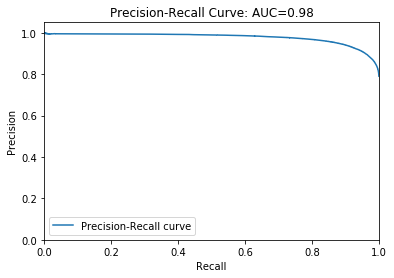

In [71]:
score_NB(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

#### Lancaster

In [72]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [73]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, cas, phon, lov, work, not, excel, very, produc, protect, perfect, nic, charg, fit, lik, us, wel, on, screen, work gre, look, easy, pric, qual, thank, gre produc, real, tim, get, very good, recommend, screen protect, nee, buy, awesom, battery, bought, fast, col, feel, cabl, expect, cov, hold, best, littl, ok, ev, purchas


Train Accuracy       0.88588
Test Accuracy        0.88009
Test Precision       0.89176
Test Recall          0.96534
F1                   0.92710
F2                   0.94967
P/R AUC              0.97633
              precision    recall  f1-score   support

       False       0.81      0.56      0.66     78224
        True       0.89      0.97      0.93    293908

    accuracy                           0.88    372132
   macro avg       0.85      0.76      0.79    372132
weighted avg       0.87      0.88      0.87    372132



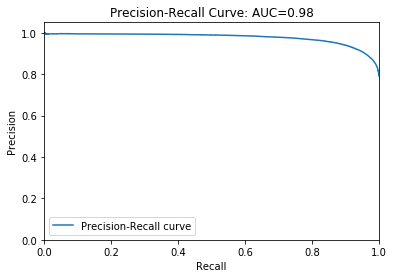

In [74]:
score_NB(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

###  PyStemmer

In [75]:
clf = MultinomialNB()
clf.fit(X_train_tfidf_pystemmer, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [76]:
print_top_features(tfidf_vect_pystemmer, clf, 50)

Most discriminative features:
 great, good, case, love, phone, work, not, veri, product, perfect, nice, excel, fit, like, use, protect, well, charg, screen, one, look, price, works great, easi, thank, qualiti, protector, great product, time, realli, get, iphon, very good, recommend, need, charger, screen protector, buy, batteri, awesom, color, bought, cabl, feel, expect, best, littl, cover, ok, fast


Train Accuracy       0.88851
Test Accuracy        0.88286
Test Precision       0.89443
Test Recall          0.96566
F1                   0.92868
F2                   0.95052
P/R AUC              0.97708
              precision    recall  f1-score   support

       False       0.82      0.57      0.67     78224
        True       0.89      0.97      0.93    293908

    accuracy                           0.88    372132
   macro avg       0.86      0.77      0.80    372132
weighted avg       0.88      0.88      0.87    372132



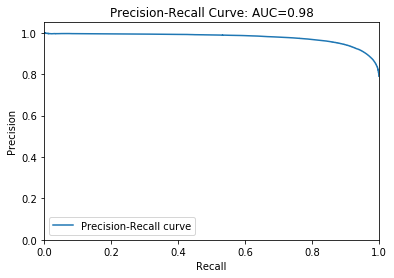

In [77]:
score_NB(clf, X_train_tfidf_pystemmer, X_test_tfidf_pystemmer, y_train, y_test)

In [78]:
beep(freq = 880)

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Porter

In [ ]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_Porter, y_train) # it takes around 30 minutes

In [ ]:
train_score = clf.score(X_train_tfidf_Porter, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_Porter, y_test)    # Test Accuracy

predictions = clf.predict(X_test_tfidf_Porter)

print(classification_report(y_test,predictions))

Results are more encouraging! The problem is that it's way slower than Multinomial NB.

## TruncatedSVD
The X_train vector has around 20k features: for speeding up the training phase it may be good to use dimensionality reduction methods. Their goal is to preserve "expressive power" while reducing dataset dimensionality.
Because the TFIDF matrix is a sparse one, one of the best method for performing dimensionality reduction is "TruncatedSVD"

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=500, random_state=42)
X_train_tfidf_Porter_svd = tsvd.fit_transform(X_train_tfidf_Porter)
X_test_tfidf_Porter_svd = tsvd.transform(X_test_tfidf_Porter)

In [ ]:
print("train with old features: ",np.array(X_train_tfidf_Porter).shape)
print("train with new features:" ,np.array(X_train_tfidf_Porter_svd).shape)

#### Store SVD-transformed dataset

In [ ]:
dump(X_train_tfidf_Porter_svd, 'X_train_tfidf_Porter_svd.joblib')
dump(X_test_tfidf_Porter_svd, 'X_test_tfidf_Porter_svd.joblib')

### Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, verbose=2)
clf.fit(X_train_tfidf_Porter_svd, y_train)

In [ ]:
predictions = clf.predict(X_test_tfidf_ps_svd)
print(classification_report(y_test,predictions))

# TODO

- Add algorithms?.
- Add *short* examples after some steps.
- Decide what to do with slang. Probably very necessary for preprocessing tweets. If we want to use it for the Amazon dataset, we might reduce the size of the dict by checking which terms are actually present in the reviews, and only keep the ones that are present in many reviews.
- Tweets part